In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [3]:
def lp_distance(X, Y, p=1):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [4]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [5]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [6]:
# 20 newsgroups
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'misc.forsale'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target

<BarContainer object of 4 artists>

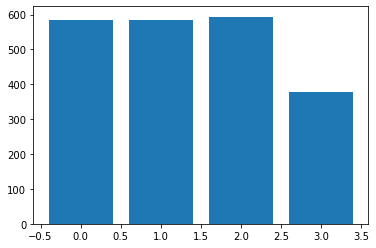

In [7]:
plt.bar(*np.unique(labels, return_counts=True))

In [8]:
#imdb_reviews
#import tensorflow_datasets as tfds
#from itertools import chain
#
#train_ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)
#test_ds = tfds.load('imdb_reviews', split='test', shuffle_files=True)
#
#texts, labels = [], []
#
#for ds in (train_ds, test_ds):
#    for example in tfds.as_numpy(ds):
#        text, label = example['text'], example['label']
#        texts.append(str(text))
#        labels.append(label)
#
#labels = np.array(labels)

In [9]:
from sklearn.model_selection import train_test_split

texts, _, labels, _ = train_test_split(texts, labels, test_size=0.9, random_state=42)

In [10]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=8, shuffle=False)

In [11]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model.to('cuda')

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [12]:
from tqdm import tqdm
embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to('cuda')
    outputs = lm_model.base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy() # 
    embeddings.append(cls_embedding)
embeddings = np.array(embeddings)

214it [00:02, 106.75it/s]


In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmean_centroids = torch.from_numpy(kmeans.cluster_centers_)
kmean_centroids = kmean_centroids.to('cuda')

In [14]:
from umap import UMAP

umap = UMAP(n_components=2)
embeddings_plot = umap.fit_transform(embeddings)

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


In [15]:
import plotly.express as px
fig = px.scatter(x=embeddings_plot[:, 0], y=embeddings_plot[:, 1], color=[f'{i}' for i in kmeans_cluster])
fig.show()

In [16]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))
print(silhouette_score(embeddings, kmeans_cluster, metric="cosine"))

0.6074766355140186
0.3933555908745504
0.36566341826778054
0.19565925


In [17]:
#import random
#random.seed(42)
#initial_centroids = np.array([embeddings[i] for i in (random.randint(0, embeddings.shape[0]-1) for _ in range(np.unique(labels).shape[0]))])
#initial_centroids = torch.from_numpy(initial_centroids).to('cuda')
#initial_centroids

In [18]:
from sklearn.cluster.k_means_ import _k_init
from sklearn.utils.extmath import row_norms

# Using KMeans++ initialization
initial_centroids = _k_init(
    embeddings,
    n_clusters=np.unique(labels).shape[0],
    x_squared_norms=row_norms(embeddings, squared=True),  #aka np.linalg.norm(embeddings, axis=1)**2
    random_state=np.random.RandomState(42))
initial_centroids = torch.from_numpy(initial_centroids).to('cuda')
initial_centroids

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.



tensor([[ 0.1709,  0.1270, -0.0172,  ...,  0.0667,  0.4118,  0.2869],
        [-0.1302, -0.0005, -0.0717,  ...,  0.2002,  0.4710,  0.5229],
        [-0.2269, -0.0134,  0.2138,  ...,  0.0597,  0.2239,  0.4506],
        [ 0.1835,  0.3056, -0.5093,  ...,  0.1397,  0.4984,  0.4074]],
       device='cuda:0')

Epoch 0 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 90.47068196502005 | Clustering Loss: 90.47068196502005 | LM Loss 2.700039863586426 | Accuracy 0.8333333333333334: : 27it [00:07,  3.49it/s]


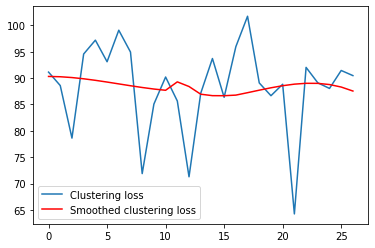

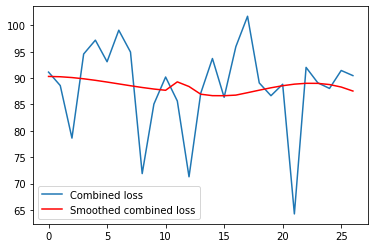

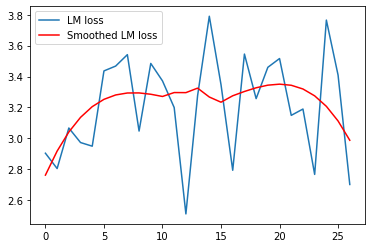

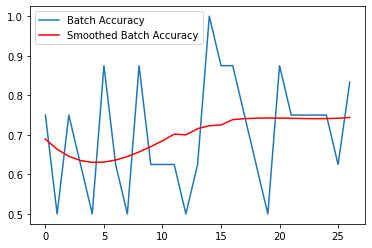

Epoch 1 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 90.34920704878095 | Clustering Loss: 90.34920704878095 | LM Loss 3.243657350540161 | Accuracy 0.8333333333333334: : 27it [00:07,  3.49it/s]


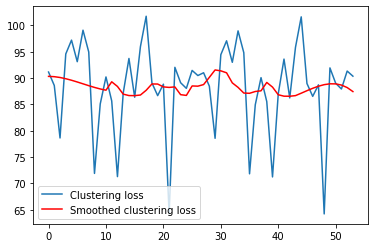

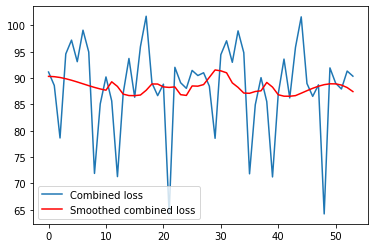

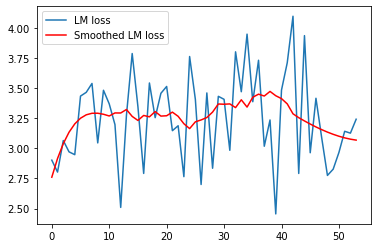

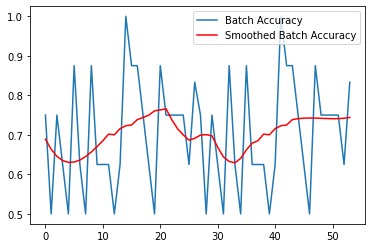

Epoch 2 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 90.22816904795354 | Clustering Loss: 90.22816904795354 | LM Loss 2.936124086380005 | Accuracy 0.8333333333333334: : 27it [00:07,  3.47it/s]


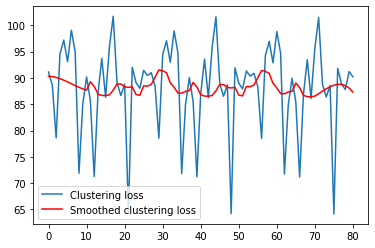

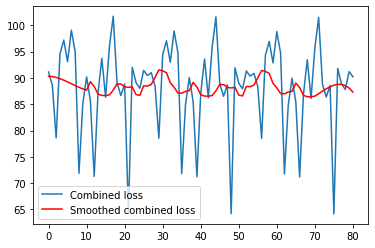

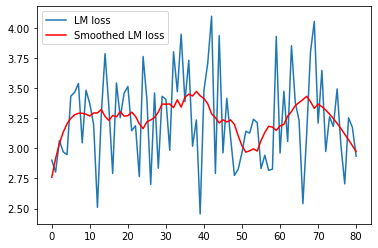

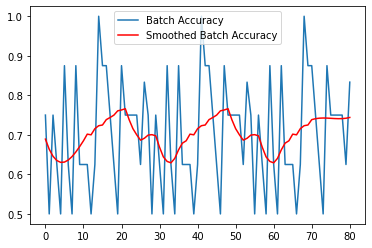

Epoch 3 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 90.10786827907805 | Clustering Loss: 90.10786827907805 | LM Loss 2.6788225173950195 | Accuracy 0.8333333333333334: : 27it [00:07,  3.46it/s]


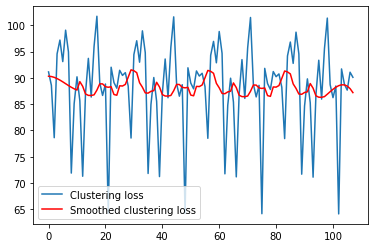

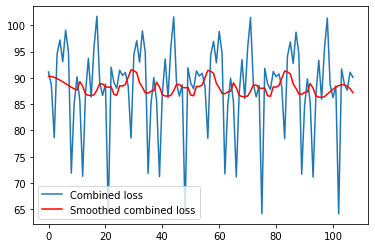

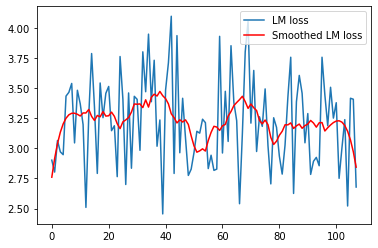

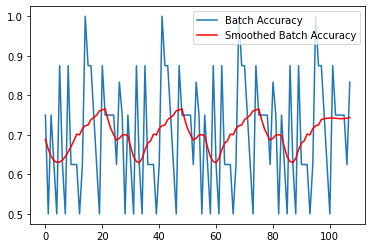

Epoch 4 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 89.9885260739652 | Clustering Loss: 89.9885260739652 | LM Loss 3.119381904602051 | Accuracy 0.8333333333333334: : 27it [00:07,  3.44it/s]


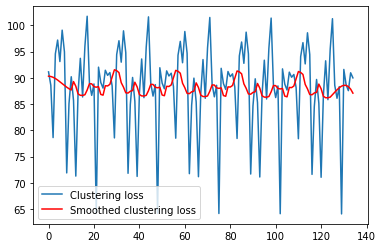

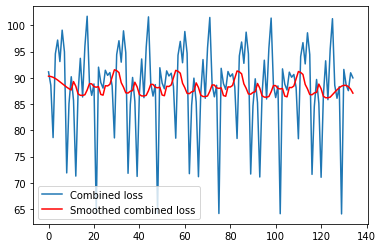

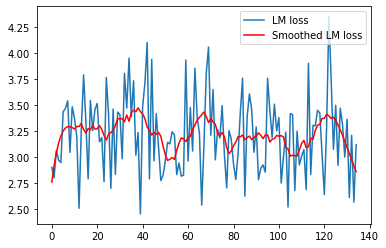

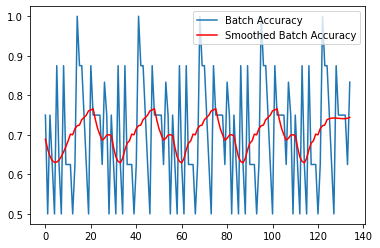

Epoch 5 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 89.86984204779401 | Clustering Loss: 89.86984204779401 | LM Loss 2.654092788696289 | Accuracy 0.8333333333333334: : 27it [00:07,  3.42it/s]


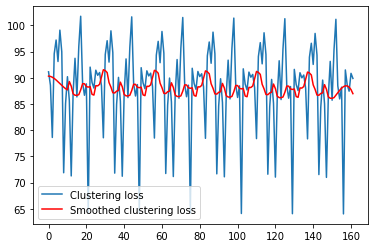

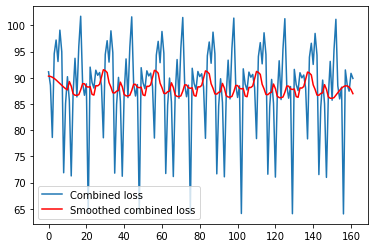

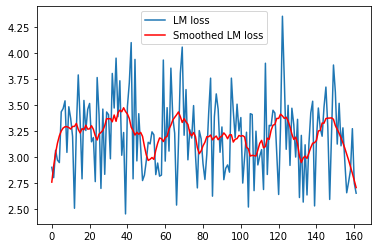

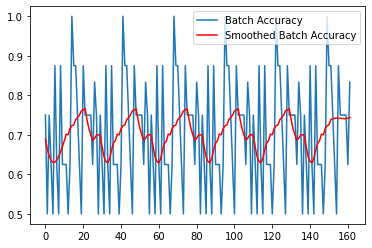

Epoch 6 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 89.75158834308604 | Clustering Loss: 89.75158834308604 | LM Loss 2.9718456268310547 | Accuracy 0.8333333333333334: : 27it [00:07,  3.40it/s]


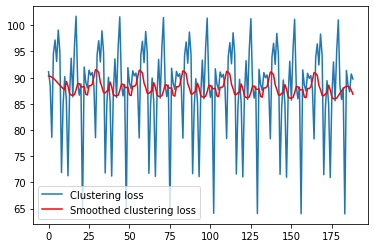

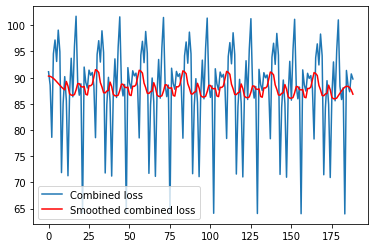

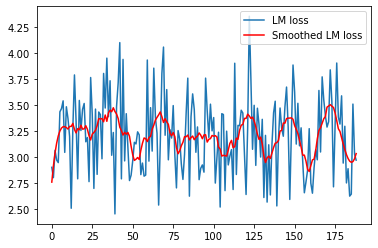

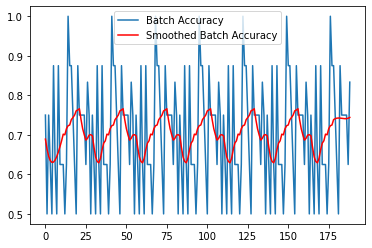

Epoch 7 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 89.63374742533799 | Clustering Loss: 89.63374742533799 | LM Loss 2.701052665710449 | Accuracy 0.8333333333333334: : 27it [00:07,  3.38it/s]


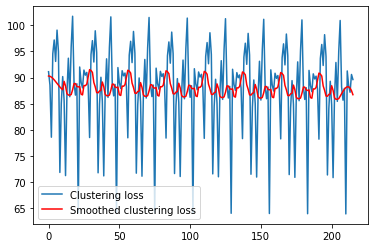

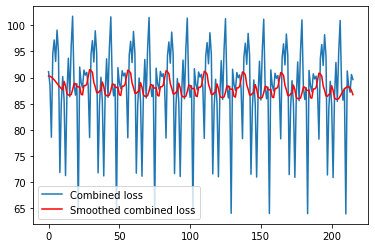

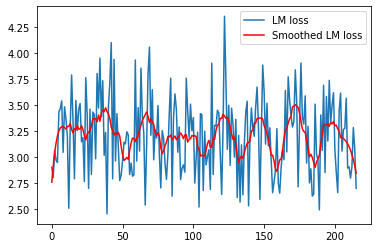

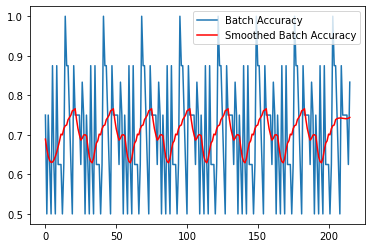

Epoch 8 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 89.51654102785142 | Clustering Loss: 89.51654102785142 | LM Loss 2.8079872131347656 | Accuracy 0.8333333333333334: : 27it [00:08,  3.36it/s]


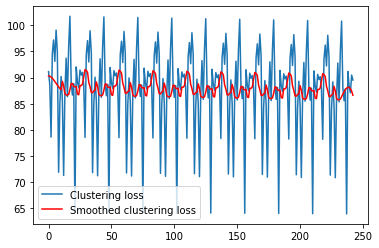

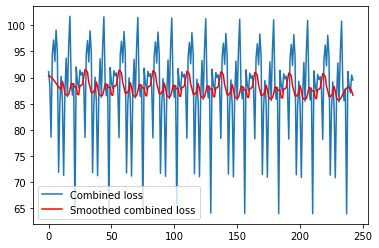

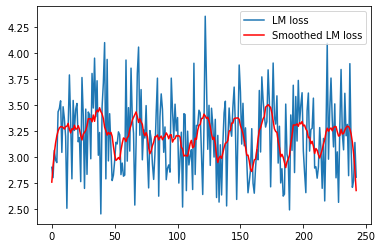

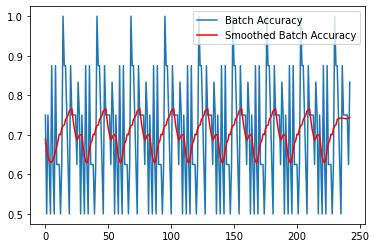

Epoch 9 (Alpha -150000000.0) | Batch: 26 | Combined Loss: 89.39997258108383 | Clustering Loss: 89.39997258108383 | LM Loss 2.9985718727111816 | Accuracy 0.8333333333333334: : 27it [00:08,  3.34it/s]


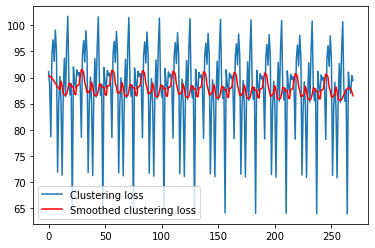

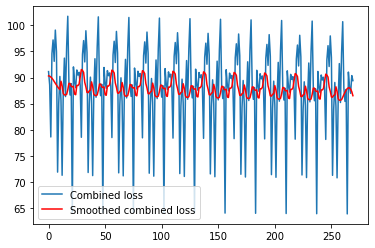

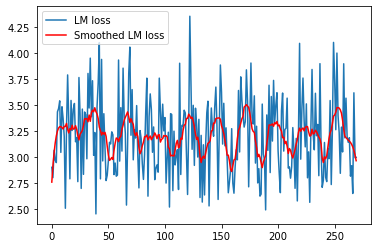

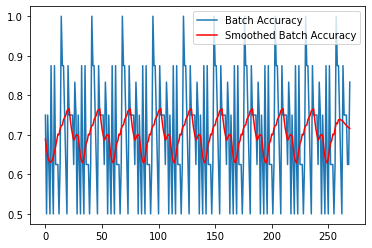

In [19]:
from scipy.signal import savgol_filter

centroids = initial_centroids.clone().to('cuda').requires_grad_(True)
#centroids = torch.Tensor(4, 768).uniform_(-10, 10).to(torch.float64).to('cuda').requires_grad_(True)
#centroids = kmean_centroids.clone().to('cuda').requires_grad_(True)  # go this way (cluster hardening)

opt = torch.optim.AdamW(
    params=[centroids], #+ list(lm_model.parameters()),
    lr = 2e-5, eps = 1e-8 )

#lm_model.train()

comb_losses = []
clustering_losses = []
lm_losses = []
c_hist = []
emb_hist = []
acc = []

n_epochs = 10
annealing_alpha = np.linspace(0.5, 2.5, n_epochs)
annealing_alpha = [1.5*100000000] * n_epochs

for epoch, alpha in zip(range(n_epochs), annealing_alpha):
    
    predicted_labels = []
    true_labels = []
    embs = []
    t = [] # improve this asap!

    c_hist.append(centroids.clone().detach().cpu().numpy())
    pbar = tqdm(enumerate(data_loader))
    for batch, batch_data in pbar:
        # lm part 
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        t.extend(texts)
        
        true_labels.extend(batch_labels)
        
        
        # clustering part
        input_ids = inputs['input_ids'].clone()
        input_ids, labels = mask_tokens(input_ids, tokenizer)
        inputs['input_ids'] = input_ids

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = lm_model(labels=labels, **inputs)
        lm_loss = outputs.loss
        
        
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        inputs.to('cuda')
        
        # 0. obtain embeddings for each input
        input_embeddings = lm_model.base_model(**inputs).last_hidden_state[:,0,:]
        input_embeddings = input_embeddings.to(torch.float64)
        
        embs.append(input_embeddings.clone().cpu().detach().numpy())

        distances = torch.stack([lp_distance(embedding.unsqueeze(0), centroids) for embedding in input_embeddings])
        #nearest_centroids = torch.argmin(distances, dim=1).cpu().clone().detach()
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax


        # 4. sum over centroids to obtain loss
        opt.zero_grad()
        
        clustering_loss = weighted_distances.sum(dim=1).mean()
        comb_loss = (lm_loss * 0) + (1 * clustering_loss) # 1.0 | 0.025
        comb_loss.backward()
        

        opt.step()

        accuracy = cluster_accuracy(batch_labels.numpy().astype('int'), nearest_centroids.numpy().astype('int'))[1]
        acc.append(accuracy)
        predicted_labels.extend(nearest_centroids.numpy())
        clustering_losses.append(clustering_loss.item())
        lm_losses.append(lm_loss.item())
        comb_losses.append(comb_loss.item())
        
        pbar.set_description(f"Epoch {epoch} (Alpha -{alpha}) | Batch: {batch} | Combined Loss: {comb_loss.item()} | Clustering Loss: {clustering_loss.item()} | LM Loss {lm_loss.item()} | Accuracy {accuracy}")
        
    emb_hist.append(embs)
    
    plt.plot(clustering_losses, label="Clustering loss")
    plt.plot(savgol_filter(clustering_losses, 21, 3), color='red', label="Smoothed clustering loss")
    plt.legend()
    plt.show()
    plt.plot(comb_losses, label="Combined loss")
    plt.plot(savgol_filter(comb_losses, 21, 3), color='red', label="Smoothed combined loss")
    plt.legend()
    plt.show()
    plt.plot(lm_losses, label="LM loss")
    plt.plot(savgol_filter(lm_losses, 21, 3), color='red', label="Smoothed LM loss")
    plt.legend()
    plt.show()
    plt.plot(acc, label="Batch Accuracy")
    plt.plot(savgol_filter(acc, 21, 3), color='red', label="Smoothed Batch Accuracy")
    plt.legend()
    plt.show()
    
    # eval part

In [20]:
np_centroids = centroids.cpu().detach().numpy()
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels).astype('int')
true_labels.shape, predicted_labels.shape

embs = np.vstack(embs)

In [21]:
print(cluster_accuracy(true_labels, predicted_labels)) # 0.6308411214953271 alpha [1.5]*n_epochs, random_state 42 kmeans++
print(normalized_mutual_info_score(true_labels, predicted_labels))
print(adjusted_rand_score(true_labels, predicted_labels))
print(silhouette_score(np.vstack(emb_hist[-1]), predicted_labels, metric="cosine"))

({0: 2, 1: 0, 2: 1, 3: 3}, 0.602803738317757)
0.3907563571161529
0.2808046365235224
0.06270016186069896


In [22]:
np.unique(predicted_labels, return_counts=True)

(array([0, 1, 2, 3]), array([66, 26, 91, 31]))

In [23]:
np.unique(true_labels, return_counts=True)

(array([0, 1, 2, 3]), array([66, 50, 59, 39]))

In [24]:
np.unique(kmeans_cluster, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([64, 13, 67, 70]))

In [25]:
from umap import UMAP
from sklearn.decomposition import PCA
reducer = UMAP(n_components=2, n_neighbors=20)
#reducer = PCA(n_components=2)
Xo = np.vstack([embs, np_centroids])
Xro = reducer.fit_transform(Xo)
labels_co = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])
label_kmeans = np.concatenate([kmeans_cluster, [f"Centroid {i}" for i in range(centroids.shape[0])]])

In [26]:
t = [" ".join(i.split()) for i in t]

In [27]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [28]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in label_kmeans], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [29]:
(np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])).all()

True

In [30]:
np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [31]:
print(* np.array(t)[np.array(predicted_labels) == 0], sep="\n"+"#"*100+"\n\n")

Of course you are a bunch of arrogant lawyers who know whats best for the rest of us. You are doing such a wonderful job with our judicial system, getting all the criminals off, I bow to your superior intellect. Not to mention the fees you collect from us poor slobs who get tickets from speeding State Police officers, so you can soak is when we go to court. I just love lawyer jokes! Don't you?
####################################################################################################

You moved from Alabama to California? My sympathies. Make sure that they have all maintenance records. Oil should be changed every 3 months. The mileage on the cars is fine. Be sure that these have the 16 valve engine. The 8 valve 318 is a BMW in name only. Didn't you have a line on a '89 325i for 12K? Jump on it.
####################################################################################################

A "fuel injector cleaning" at the dealer is probably little more than them opening 

In [32]:
np.unique(predicted_labels)

array([0, 1, 2, 3])

In [33]:
np.unique(true_labels)

array([0, 1, 2, 3])

In [34]:
np.vstack(emb_hist[-1])

array([[-0.10279943, -0.15052402,  0.17604455, ..., -0.17475799,
         0.20952965,  0.50192463],
       [-0.01244512, -0.09272797,  0.06229213, ...,  0.08165854,
         0.32516056,  0.40829623],
       [-0.04251773, -0.0796175 , -0.0398921 , ...,  0.2043066 ,
         0.3364737 ,  0.35601047],
       ...,
       [ 0.06797461,  0.04038552, -0.10060333, ...,  0.03643636,
         0.2031997 ,  0.38966492],
       [-0.38471437, -0.18162218,  0.01727451, ..., -0.026247  ,
         0.04848332,  0.39430603],
       [-0.33467981, -0.14440125,  0.08104146, ..., -0.09377625,
         0.10395038,  0.62227196]])

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(true_labels).shape[0], n_init=20)

end_embeddings_kmeans_cluster = kmeans.fit_predict(np.vstack(emb_hist[4]))

In [36]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(true_labels, end_embeddings_kmeans_cluster)[1])
print(normalized_mutual_info_score(true_labels, end_embeddings_kmeans_cluster))
print(adjusted_rand_score(true_labels, end_embeddings_kmeans_cluster))

0.5420560747663551
0.3191667965952878
0.27185236234717736


In [37]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), end_embeddings_kmeans_cluster, metric="cosine")

0.1992338718691896

In [38]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), predicted_labels, metric="cosine")

0.06270016186069896